## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [85]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [86]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [87]:
len(df)

294478

c. The number of unique users in the dataset.

In [88]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [89]:
len(df.query('converted == 1'))/df['user_id'].nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [90]:
count1 = len(df.query('group=="treatment" & landing_page == "old_page"'))
count2 = len(df.query('group=="control" & landing_page=="new_page"'))
count1 + count2

3893

f. Do any of the rows have missing values?

In [91]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [92]:
df2 = df.query('(group=="treatment" & landing_page == "new_page") | (group=="control" & landing_page=="old_page")')

In [93]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [94]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [95]:
df2[df2.duplicated(['user_id'])]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [96]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [97]:
df2 = df2.drop_duplicates('user_id')

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [98]:
len(df2.query('converted == 1'))/len(df2['converted'])

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [99]:
p_control = len(df2.query('converted == 1 & group == "control"'))/len(df2.query('group == "control"'))
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [100]:
p_treatment = len(df2.query('converted == 1 & group == "treatment"'))/len(df2.query('group == "control"'))
p_treatment

0.1188375070556328

d. What is the probability that an individual received the new page?

In [101]:
len(df2.query('landing_page == "new_page"'))/len(df2['landing_page'])

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There definitely isn't evidence enough to conclude that the new treatment page leads to more conversions. The percentage of users who convert is roughly the same regardless of which page they received. We can't blame small/mismatched sample sizes, either, since there is essentially the same number of people in the treatment group as in the control group.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$: $p_{new}$ ≤ $p_{old}$ <br>
$H_{1}$: $p_{new}$ > $p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [102]:
len(df2.query('converted == 1'))/len(df2['converted'])

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [103]:
len(df2.query('converted == 1'))/len(df2['converted'])

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [104]:
n_new = len(df2.query('group=="treatment"'))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [105]:
n_old = len(df2.query('group=="control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [106]:
new_page_converted = []
for _ in range(n_new):
    b_samp = df2.sample(n=1, replace=True)
    new_page_converted.append(b_samp.iloc[0]['converted'])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [107]:
old_page_converted = []
for _ in range(n_old):
    b_samp = df2.sample(n=1, replace=True)
    old_page_converted.append(b_samp.iloc[0]['converted'])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [108]:
np.array(new_page_converted).mean()-np.array(old_page_converted).mean()

0.00028007749100023016

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [109]:
p_diffs = np.zeros(10000)
for i in range(10000):
    b_samp_new = df2.sample(n=n_new, replace=True)
    b_samp_old = df2.sample(n=n_old, replace=True)
    p_new = np.array(b_samp_new['converted']).mean()
    p_old = np.array(b_samp_old['converted']).mean()
    p_diffs[i] = p_new - p_old

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   22.,   124.,   537.,  1490.,  2524.,  2758.,  1693.,   664.,
          170.,    18.]),
 array([ -4.35188437e-03,  -3.49773868e-03,  -2.64359300e-03,
         -1.78944732e-03,  -9.35301632e-04,  -8.11559487e-05,
          7.72989735e-04,   1.62713542e-03,   2.48128110e-03,
          3.33542678e-03,   4.18957247e-03]),
 <a list of 10 Patch objects>)

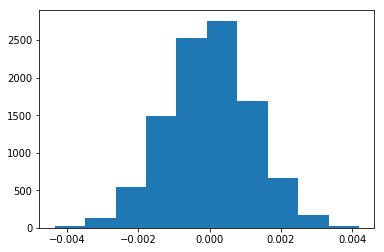

In [110]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [111]:
obs_diff = p_treatment - p_control
(p_diffs > obs_diff).mean()

0.89970000000000006

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value computed above is called the p-value. The calculated p-value is much greater than the significance level of 5% meaning we fail to reject the null hypothesis. In other words, the probability of conversion when visiting the old page is greater than or equal to the probability of conversion when visiting the new page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [112]:
import statsmodels.api as sm

convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [113]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
z_score, p_value

(1.3109241984234394, 0.18988337448195103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score does not lie outside the range -1.96 and 1.96 so the difference in conversion rates between the new page and old page are not statistically different. The p-value is greater than 0.05 also indicating that they are not statistically different. These findings agree with my findings in parts j and k, however the p-value is much smaller when using the built in.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [114]:
df2['intercept'] = 1

df2[['treatment','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('treatment',axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [115]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [116]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        00:10:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page is 0.19 or 19%. This is different from the value found in Part II because the null hypothesis associated with the A/B test is $p_{new}$ is less than or equal to $p_{old}$ while the null hypothesis associated with the logistic regression model is that there is no relationship between conversion rate and page received by the user. They are testing different null hypotheses so the p-value will necessarily be different since p-value is a measure of how much evidence we have against the null hypothesis.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It's a good idea to add other factors to the regression model if we want to consider the statistical significance of multiple factors relative to eachother. A disadvantage of adding more factors to a regression model is that it lowers the precision of the statistical estimates by lowering coefficients and increasing variance.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [117]:
df_countries = pd.read_csv('countries.csv')
pd.unique(df_countries['country'])

array(['UK', 'US', 'CA'], dtype=object)

In [118]:
df_countries[['CA','UK','US']] = pd.get_dummies(df_countries['country'])
df_countries = df_countries.drop('CA',axis = 1)
df_countries.head()

,user_id,country,UK,US
0,834778,UK,1,0
1,928468,US,0,1
2,822059,UK,1,0
3,711597,UK,1,0
4,710616,UK,1,0


In [119]:
df_countries = df_countries.drop('country', axis = 1)
df2 = df2.merge(df_countries, on = 'user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1


In [120]:
df2['intercept'] = 1
logit_mod = sm.Logit(df2['converted'], df2[['intercept','UK','US']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 26 Feb 2019   Pseudo R-squ.:               1.521e-05
Time:                        00:10:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**There appears to be no significant relationship between country and conversion since the p-values are above 5%.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [121]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','UK','US','ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 26 Feb 2019   Pseudo R-squ.:               2.323e-05
Time:                        00:10:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

**None of the factors have a statistically significant relationship with conversion rate.**

In [122]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0